In [206]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import lightgbm as gbm
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import os
pd.set_option('display.max_columns', None)

In [207]:
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
test = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [208]:
def summaryStats(data:pd.DataFrame):
  print('\n\n-------Quick Look Data--------')
  print(data.head())

  print('\n\n-------Quick Stat Check--------')
  print(data.describe())
  
  print('\n\n-------Info--------')
  print(data.info())

  print('\n\n-------Checking Null--------')
  print(data.isna().sum())
  print('length of the table = %d' %len(data))

In [209]:
summaryStats(train);



-------Quick Look Data--------
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


-------Quick Stat Check--------
              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.00000

In [210]:
#prome, schoolHoliday, open, dayof week can fit to int8 and we wont loose any information

In [211]:
summaryStats(test)



-------Quick Look Data--------
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0


-------Quick Stat Check--------
                 Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.000000 

In [212]:
#we check the missing open data
summaryStats(store)



-------Quick Look Data--------
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  

In [213]:
#decrease the memory usage 
#prome, schoolHoliday, open, dayof week can fit to int8 and we wont loose any information
features = ['DayOfWeek','Open','Promo','SchoolHoliday']
for feature in features:
  train[feature] = train[feature].astype(np.int8)

for feature in ['Store','Sales','Customers']:
  train[feature] = train[feature].astype(np.int32)
train.info()


#we decrease the usage higher than %50
#store, sales,customers is can fit to int32

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int32 
 1   DayOfWeek      1017209 non-null  int8  
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int32 
 4   Customers      1017209 non-null  int32 
 5   Open           1017209 non-null  int8  
 6   Promo          1017209 non-null  int8  
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int8  
dtypes: int32(3), int8(4), object(2)
memory usage: 31.0+ MB


In [214]:

#Id,store,dayofweek,open,Promo,SchoolHoliday can fit to int8 and int32
features  = ['Store','DayOfWeek','Promo','SchoolHoliday']
for feature in features:
  test[feature] = test[feature].astype(np.int8)

#test['Id'] = test["Id"].astype(np.int32)

test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int8   
 2   DayOfWeek      41088 non-null  int8   
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int8   
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int8   
dtypes: float64(1), int64(1), int8(4), object(2)
memory usage: 1.4+ MB


<AxesSubplot:xlabel='Date', ylabel='Sales'>

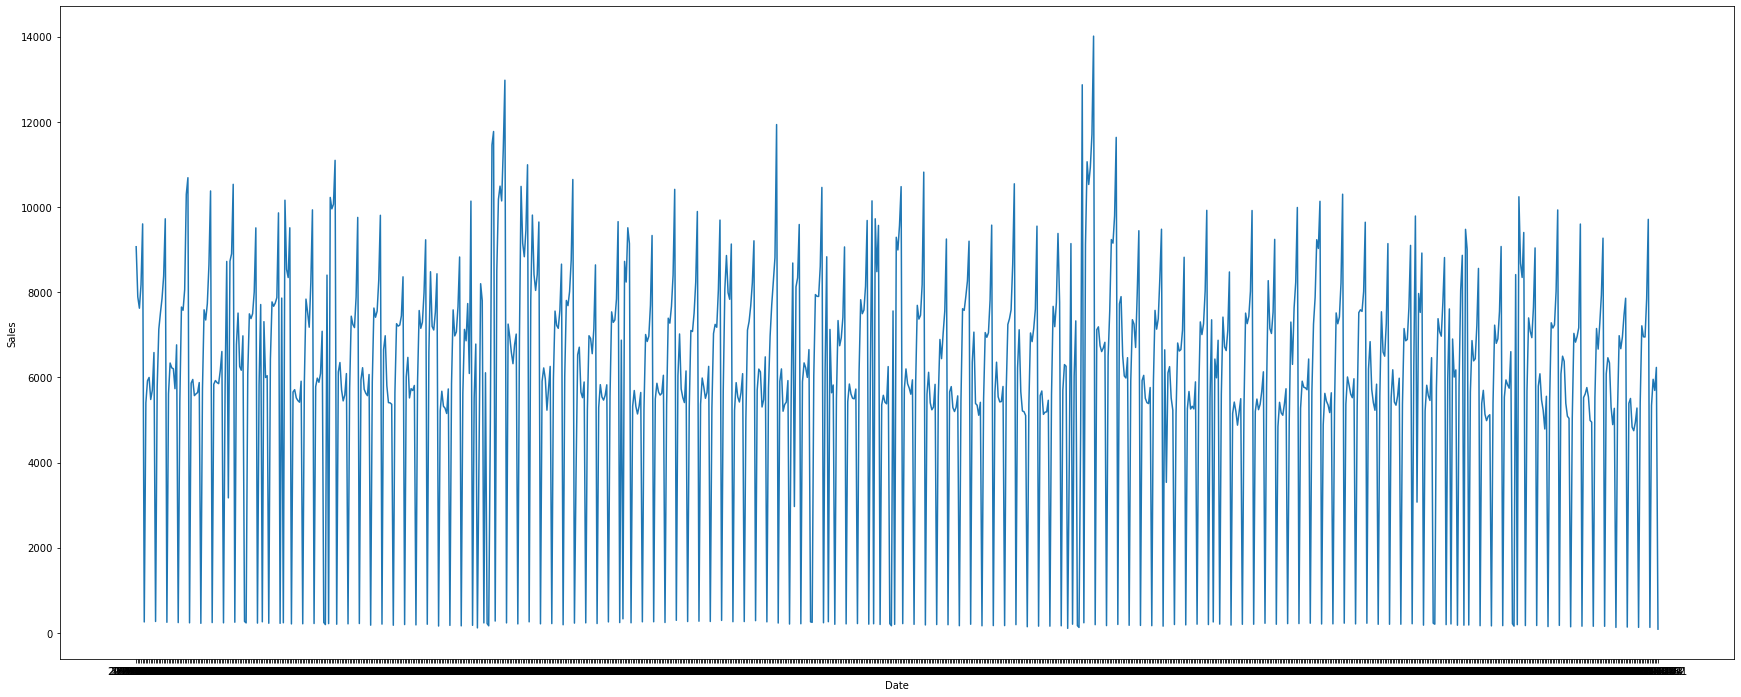

In [215]:
#eda


plt.figure(figsize=(30,12))
sns.lineplot(x='Date',y= 'Sales',data=train,ci=None )
#the sale is stationary I presume by looking data and I think there is a trend in very similar time.

<AxesSubplot:xlabel='Sales', ylabel='Count'>

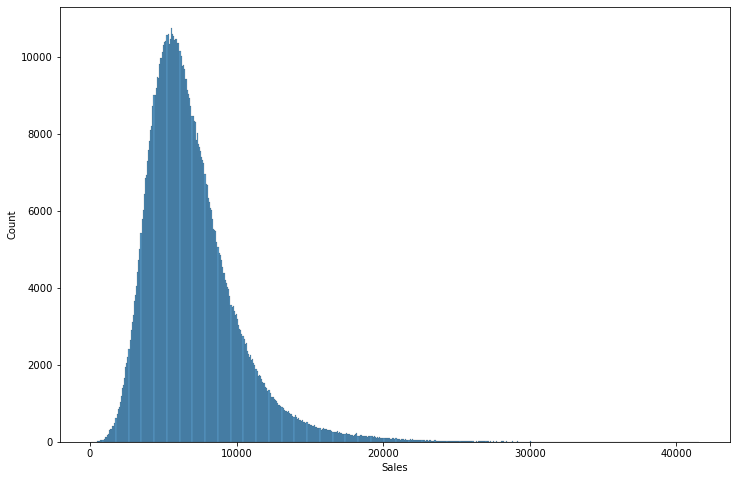

In [216]:
#we see that there is a outlier in the detrend
#the data skewed to left, I will transform later.
plt.figure()
sns.histplot(train.loc[train['Sales']!=0,'Sales'])

In [217]:
train['Date'] = pd.to_datetime(train['Date'],format='%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'],format='%Y-%m-%d')

In [218]:
storegroup =train.groupby('Store')['Sales'].sum()
storegroup.columns= ['Store','Sales']
best20Store =storegroup.sort_values(ascending=False)[:20] 
plt.figure(figsize=(20,12))


<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<AxesSubplot:xlabel='DayOfWeek'>

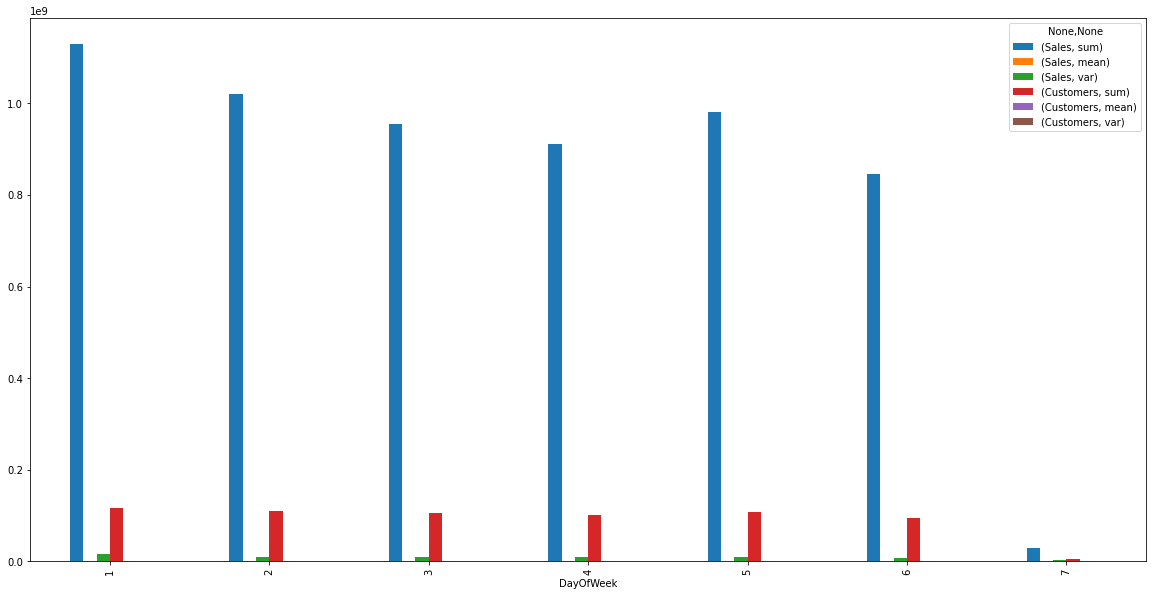

In [219]:
dayofWeekgroup = train.groupby('DayOfWeek')[['Sales','Customers']].agg(['sum','mean','var'])
dayofWeekgroup.plot(kind='bar',figsize=(20,10))
#at sunday the shopping drop drastically, we can create a feature which indicates it is sunday.
#or we can mean encode the week day number

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='StateHoliday', ylabel='count'>

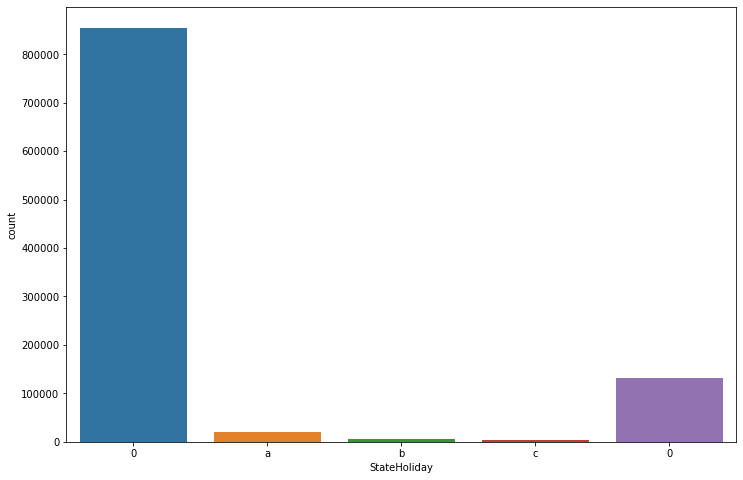

In [220]:
sns.countplot(train['StateHoliday'])
#there is a problem or data leakage, there is a str 0 and number 0 why it can be happened?

In [221]:
train.loc[train['StateHoliday'] =='0','StateHoliday'] = 0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sales'>

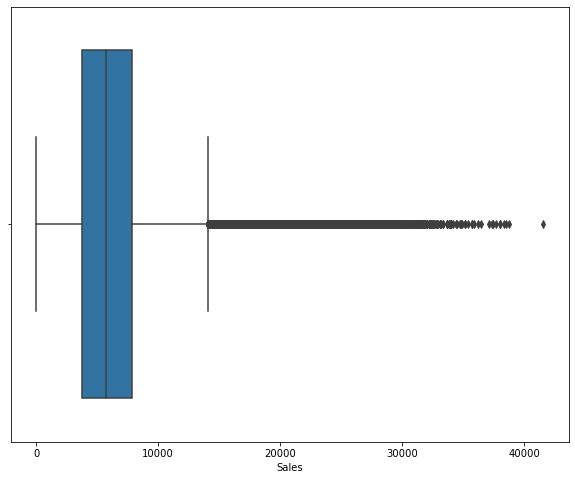

In [222]:
plt.figure(figsize=(10,8))
sns.boxplot(train['Sales'])

In [223]:
train.drop(train[train['Sales']>40000].index,inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Customers'>

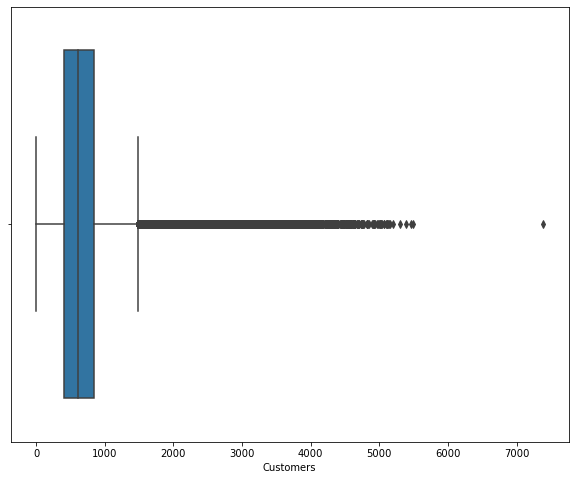

In [224]:
plt.figure(figsize=(10,8))
sns.boxplot(train['Customers'])

In [225]:
train.drop(train[train['Customers']>7000].index,inplace=True)


In [226]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int8          
 2   DayOfWeek      41088 non-null  int8          
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41077 non-null  float64       
 5   Promo          41088 non-null  int8          
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int64(1), int8(4), object(1)
memory usage: 1.4+ MB


In [227]:
#open has na in test set

test[test['Open'].isna() ==True]
#this NaN value occured on consecutive number of days and happened in the same store only. Thus, I fill this NaN with 1.
test.loc[test['Open'].isna() ==True,'Open'] =1 

In [228]:
test['Open'] = test['Open'].astype(np.uint8)

In [229]:
#i can drop the id column it has no meaning now
test.drop(columns='Id',inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          41088 non-null  int8          
 1   DayOfWeek      41088 non-null  int8          
 2   Date           41088 non-null  datetime64[ns]
 3   Open           41088 non-null  uint8         
 4   Promo          41088 non-null  int8          
 5   StateHoliday   41088 non-null  object        
 6   SchoolHoliday  41088 non-null  int8          
dtypes: datetime64[ns](1), int8(4), object(1), uint8(1)
memory usage: 842.8+ KB


In [230]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [231]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


<AxesSubplot:xlabel='Promo2', ylabel='count'>

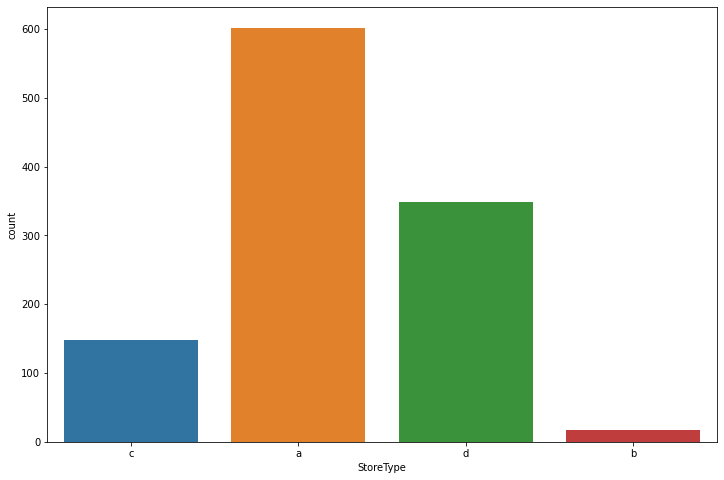

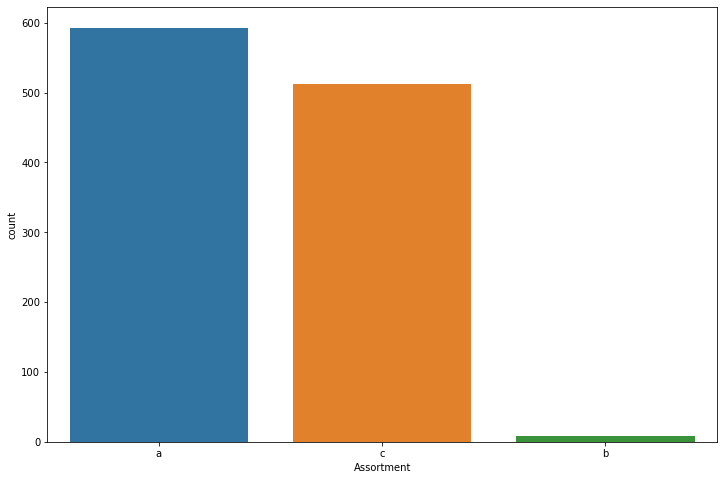

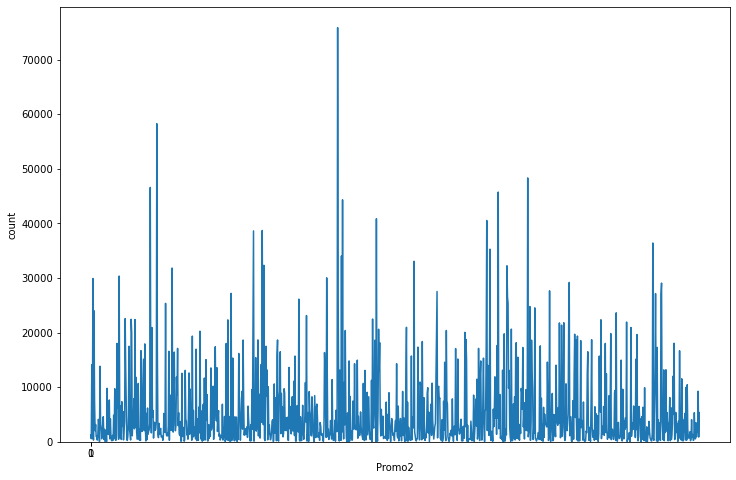

In [232]:
sns.countplot(x='StoreType',data=store)
plt.figure()
sns.countplot(x='Assortment',data=store)
plt.figure()
sns.countplot(x='Promo2',data=store)
sns.lineplot(ci=None,data=store['CompetitionDistance'])

In [233]:
store[['Promo2SinceWeek','Promo2SinceYear']] = store[['Promo2SinceWeek','Promo2SinceYear']].fillna(0)
store['PromoInterval'] =store['PromoInterval'].fillna('None')
store.head()
#i fill with 0 because promo2 is 0 on the missing values.

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None


In [234]:
store.loc[np.where(store['CompetitionOpenSinceMonth'].isna())]
#we have no clue why these are missing.
#in CompetitionDistance has 3 missing value and it can filled with groupby operation.
#for just now I fill the others with the same way.

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,None
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,None
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,None


In [235]:
store.loc[np.where(store['CompetitionDistance'].isna())]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,0.0,0.0,None
621,622,a,c,NaN,NaN,NaN,0,0.0,0.0,None
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [236]:
#we fill those null values 
store['CompetitionDistance'] = store.groupby(['StoreType','Assortment'])['CompetitionDistance'].transform(lambda x:x.fillna(x.mean()))
store['CompetitionOpenSinceMonth'] =store.groupby(['StoreType','Assortment'])['CompetitionOpenSinceMonth'].transform(lambda x:x.fillna((x.mean())))
store.loc[561,'CompetitionOpenSinceMonth'] = store.CompetitionOpenSinceMonth.mean()
store['CompetitionOpenSinceYear'] =store.groupby(['StoreType','Assortment'])['CompetitionOpenSinceYear'].transform(lambda x:x.fillna((x.mean())))
store.loc[561,'CompetitionOpenSinceYear'] = store.CompetitionOpenSinceYear.mean()
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].apply(round)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].apply(round)

In [237]:
store['PromoInterval'+str('_1')] = store['PromoInterval'].apply(lambda x: x.split(',')[0] if x !="None" else x)
store['PromoInterval'+str('_2')] = store['PromoInterval'].apply(lambda x: x.split(',')[1] if x !="None" else x)
store['PromoInterval'+str('_3')] = store['PromoInterval'].apply(lambda x: x.split(',')[2] if x !="None" else x)
store['PromoInterval'+str('_4')] = store['PromoInterval'].apply(lambda x: x.split(',')[3] if x !="None" else x)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4
0,1,c,a,1270.0,9,2008,0,0.0,0.0,None,None,None,None,None
1,2,a,a,570.0,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
2,3,a,a,14130.0,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jan,Apr,Jul,Oct
3,4,c,c,620.0,9,2009,0,0.0,0.0,None,None,None,None,None
4,5,a,a,29910.0,4,2015,0,0.0,0.0,None,None,None,None,None


In [238]:
#we split the promoInterval we can drop it.
store.drop(columns='PromoInterval',inplace=True)
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4
0,1,c,a,1270.0,9,2008,0,0.0,0.0,None,None,None,None
1,2,a,a,570.0,11,2007,1,13.0,2010.0,Jan,Apr,Jul,Oct
2,3,a,a,14130.0,12,2006,1,14.0,2011.0,Jan,Apr,Jul,Oct
3,4,c,c,620.0,9,2009,0,0.0,0.0,None,None,None,None
4,5,a,a,29910.0,4,2015,0,0.0,0.0,None,None,None,None


In [239]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
store.StoreType.replace(mappings, inplace=True)
store.Assortment.replace(mappings, inplace=True)
train.StateHoliday.replace(mappings, inplace=True)
test.StateHoliday.replace(mappings, inplace=True)

In [240]:
store.info()
number = {'Store':np.int32,
          'CompetitionOpenSinceMonth':np.int32,
          'CompetitionOpenSinceYear':np.int32,
          'Promo2':np.int8,
          'Promo2SinceWeek':np.int8,
          'Promo2SinceYear':np.int32,
          'CompetitionDistance':np.float32}


for key in number:
  store[key] =store[key].astype(number[key])
store.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   int64  
 2   Assortment                 1115 non-null   int64  
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int64  
 5   CompetitionOpenSinceYear   1115 non-null   int64  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval_1            1115 non-null   object 
 10  PromoInterval_2            1115 non-null   object 
 11  PromoInterval_3            1115 non-null   object 
 12  PromoInterval_4            1115 non-null   object 
dtypes: float64(3), int64(6), object(4)
memory usage:

In [241]:
#now we can merge the both data to mean encode them.
# train =pd.merge(train,store,how='left',on='Store')
# train.head()
# train.info()


              Sales  Customers
Sales      1.000000   0.983707
Customers  0.983707   1.000000


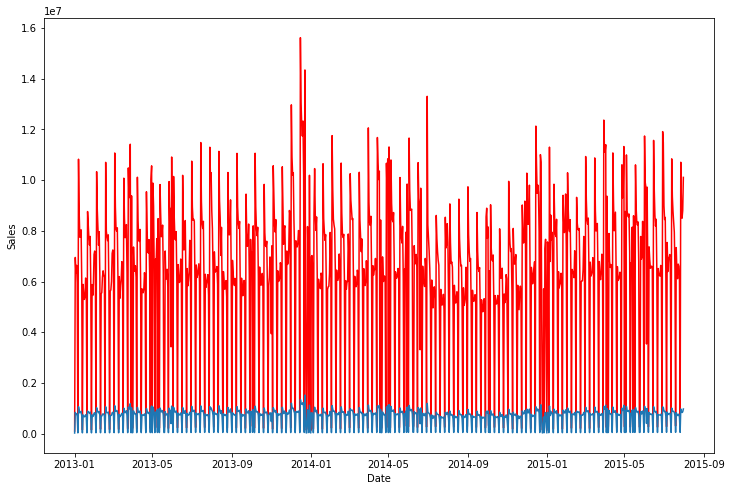

In [242]:
#first look the data on groupby by data
date =train.groupby('Date')[['Sales','Customers']].sum()
date.head()
plt.figure(figsize=(12,8))
sns.lineplot(y='Sales',x = 'Date',data=date,ci=None,color='red')

sns.lineplot(y='Customers',x = 'Date',data=date,ci=None)
print(date.corr())
#they have a big correlation

In [243]:
from statsmodels.tsa.stattools import adfuller

stattest= adfuller(date['Sales'])
stattest
#we convert the data daily because otherwise it will count a the same day a new one.

(-4.761994918555573,
 6.426028767609414e-05,
 20,
 921,
 {'1%': -3.437470108019385,
  '5%': -2.8646832620852853,
  '10%': -2.5684436698650503},
 29155.569547992724)

<AxesSubplot:xlabel='Customers', ylabel='Count'>

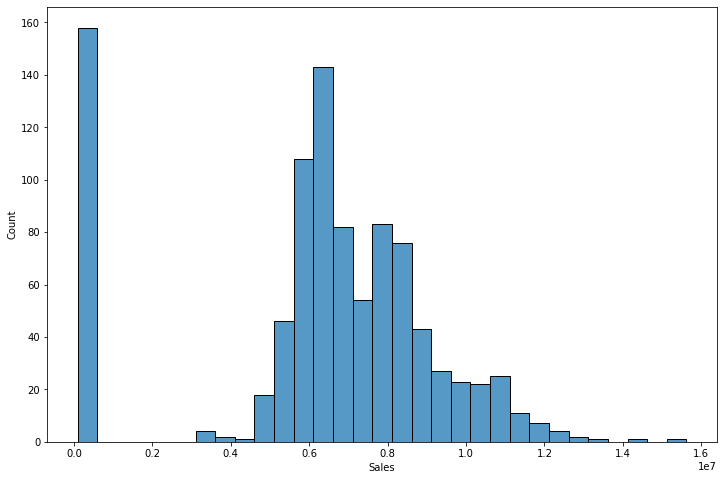

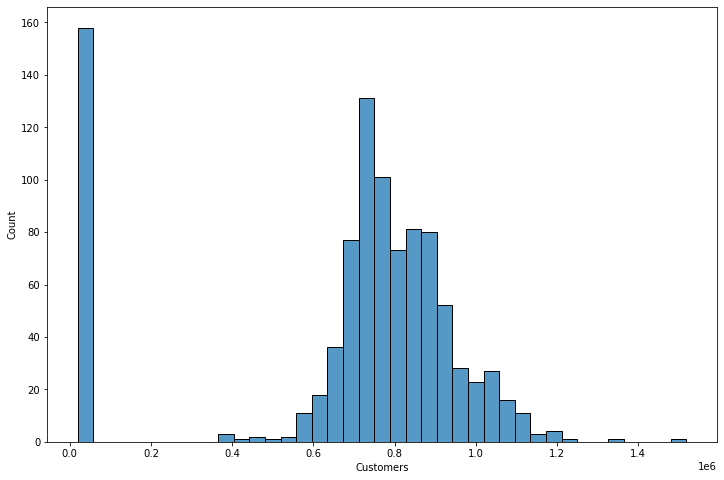

In [244]:
#we see that adfuller test score is -4.76 something and our conf interval at %99 
# is equal to -3.43 something that means we can reject the null hyp.
# and also our p_value is way lower than 0.05
sns.histplot(date['Sales'])
plt.figure()
sns.histplot(date['Customers'])
#we have a huge problem in this data
#I need to check it even I sum them in daily 

In [245]:
train.loc[np.where((train['Sales'] == 0) & (train['Open']==1))].sort_values('Store')
#this is a big data leakage, but i keep them as it is now I will deal with them later.
train.drop(train.loc[((train['Sales'] == 0) & (train['Open']==1))].index,inplace=True)

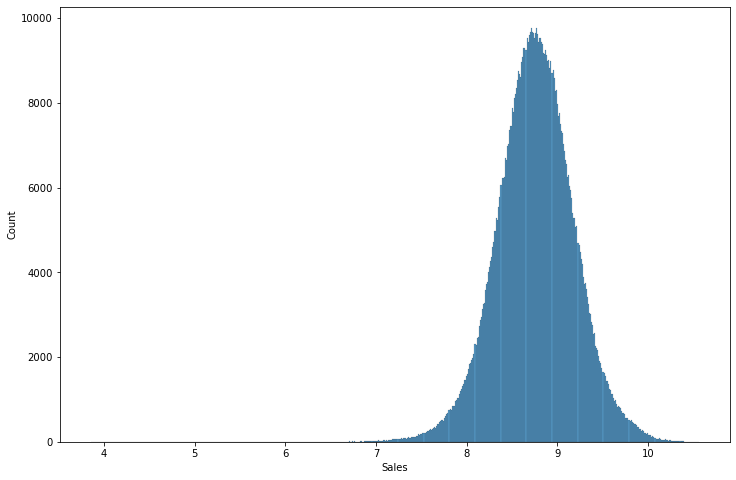

In [246]:
#######
train = train[train['Sales']!= 0]
plt.figure(figsize=(12,8))
sns.histplot((np.log1p(train['Sales'])))
train['Sales'] = np.log1p(train['Sales'])
train['Customers'] = np.log1p(train['Customers'])



In [247]:
test['Sales'],test['Customers'] =0,0

test  = test.reindex(['Store','DayOfWeek','Date','Sales','Customers','Open','Promo','StateHoliday','SchoolHoliday'],axis=1)
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,0,0,1,1,0,0
1,3,4,2015-09-17,0,0,1,1,0,0
2,7,4,2015-09-17,0,0,1,1,0,0
3,8,4,2015-09-17,0,0,1,1,0,0
4,9,4,2015-09-17,0,0,1,1,0,0


In [248]:
test.loc[np.where(test['Open'].isna())]
#I checked it in these days the store was closed.
test.loc[np.where(test['Open'].isna())[0],'Open'] = 0
test['Open'] = test['Open'].astype(np.int8)
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-09-17,0,0,1,1,0,0
1,3,4,2015-09-17,0,0,1,1,0,0
2,7,4,2015-09-17,0,0,1,1,0,0
3,8,4,2015-09-17,0,0,1,1,0,0
4,9,4,2015-09-17,0,0,1,1,0,0


In [249]:
%time
X = test.copy()
X = X.append(train)
X.info()
#We merge them to use lag features correctly, because the test set is the next dates after train set.


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
<class 'pandas.core.frame.DataFrame'>
Int64Index: 885424 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          885424 non-null  int32         
 1   DayOfWeek      885424 non-null  int8          
 2   Date           885424 non-null  datetime64[ns]
 3   Sales          885424 non-null  float64       
 4   Customers      885424 non-null  float64       
 5   Open           885424 non-null  int8          
 6   Promo          885424 non-null  int8          
 7   StateHoliday   885424 non-null  int64         
 8   SchoolHoliday  885424 non-null  int8          
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), int8(4)
memory usage: 40.5 MB


In [250]:
%time
X['SalesPerCustomer'] = X['Sales']/X['Customers']
X[50000:50005]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer
10011,1092,4,2015-07-23,9.345133,6.981006,1,0,0,0,1.338651
10012,1093,4,2015-07-23,8.927314,6.690842,1,0,0,1,1.334259
10013,1094,4,2015-07-23,8.517393,5.973810,1,0,0,0,1.425789
10014,1095,4,2015-07-23,8.262301,6.383507,1,0,0,1,1.294320
10015,1096,4,2015-07-23,8.336390,6.210600,1,0,0,1,1.342284


In [251]:
def lagFeature(data:pd.DataFrame,lags:list,feature:list):
  """ This method will create lag feature on customers and Sales 
      and it will also used to groupby with other features."""
  for feat in feature:
    for lag in lags:
      col = feat+'_lag_'+str(lag)+'_daily_'
      data[col] = data.groupby('Store')[feat].shift(lag)
  return data


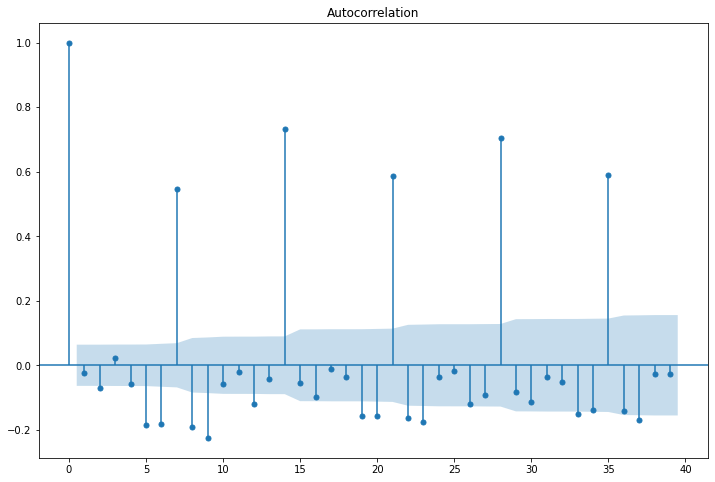

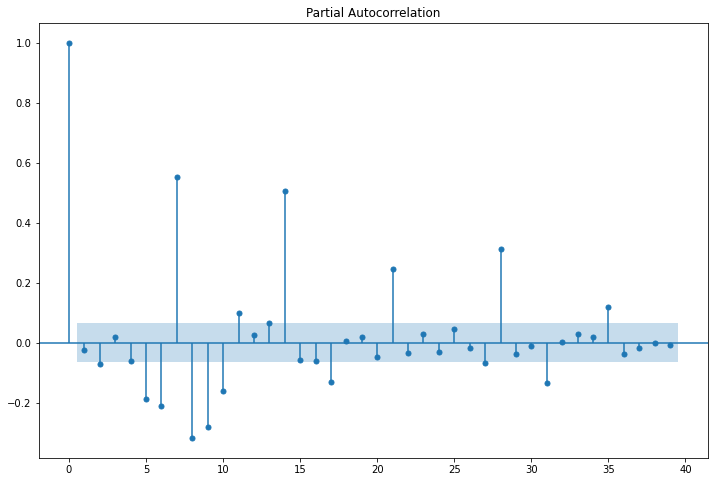

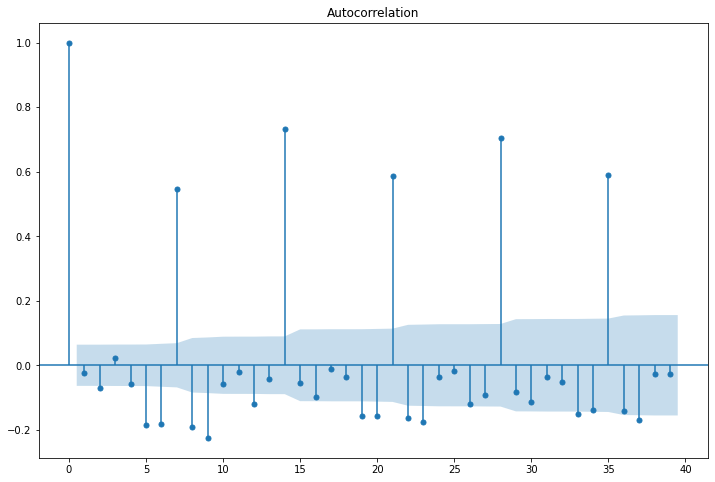

In [252]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

plot_pacf(date.Sales,lags=list(range(0,40)))
plot_acf(date.Sales,lags=list(range(0,40)))
#we see that there is a high corr on weekly
#for that reason I create lag for 14 day 
#2 weeks and 1 month corr

In [253]:
%%time
lags=[1,2,3,7,14,21]
X = lagFeature(X,lags,['Sales','Customers'])


CPU times: user 301 ms, sys: 1 ms, total: 303 ms
Wall time: 301 ms


In [254]:
X[50000:50010]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_
10011,1092,4,2015-07-23,9.345133,6.981006,1,0,0,0,1.338651,9.244355,9.625888,9.664596,9.724779,NaN,NaN,6.958448,7.153834,7.248504,7.321850,NaN,NaN
10012,1093,4,2015-07-23,8.927314,6.690842,1,0,0,1,1.334259,8.943767,8.718827,9.380589,9.374074,NaN,NaN,6.688355,6.442540,6.950815,6.977281,NaN,NaN
10013,1094,4,2015-07-23,8.517393,5.973810,1,0,0,0,1.425789,8.324094,8.688285,8.791942,8.670258,NaN,NaN,5.837730,6.107023,6.018593,6.054439,NaN,NaN
10014,1095,4,2015-07-23,8.262301,6.383507,1,0,0,1,1.294320,8.360071,8.062433,8.762490,8.508959,NaN,NaN,6.408529,6.222576,6.602588,6.546785,NaN,NaN
10015,1096,4,2015-07-23,8.336390,6.210600,1,0,0,1,1.342284,8.510169,8.359135,9.012377,9.139811,NaN,NaN,6.361302,6.163315,6.542472,6.705639,NaN,NaN
10016,1097,4,2015-07-23,9.172742,7.879291,1,0,0,0,1.164158,9.205227,8.962007,9.496121,9.242323,NaN,NaN,7.932003,7.599401,7.905073,7.760893,NaN,NaN
10017,1098,4,2015-07-23,8.340456,6.385194,1,0,0,1,1.306218,8.428799,7.770645,8.898092,8.765771,NaN,NaN,6.405228,5.752573,6.769642,6.660575,NaN,NaN
10018,1099,4,2015-07-23,9.070848,7.152269,1,0,0,1,1.268248,9.362546,8.910451,8.645410,9.134647,NaN,NaN,7.290975,6.977281,6.870053,6.967909,NaN,NaN
10019,1100,4,2015-07-23,8.154213,6.257668,1,0,0,1,1.303075,8.285261,7.863267,8.922525,8.891649,NaN,NaN,6.333280,5.736572,6.559615,6.709304,NaN,NaN
10020,1101,4,2015-07-23,9.107421,6.801283,1,0,0,1,1.339074,8.989320,8.971321,9.615539,9.510593,NaN,NaN,6.720220,6.670766,7.094235,7.013915,NaN,NaN


In [255]:
%%time
def fill_na(data):
  for col in data.columns:
    if 'lag' in col or 'mean' in col or 'max' in col:
      data[col]=data[col].fillna(0)
      data[col] =data[col].astype(np.float32)
  return data
X = fill_na(X)
X.SalesPerCustomer = X.SalesPerCustomer.fillna(0)

CPU times: user 67.9 ms, sys: 998 µs, total: 68.9 ms
Wall time: 67.6 ms


In [256]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885424 entries, 0 to 1017190
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Store                    885424 non-null  int32         
 1   DayOfWeek                885424 non-null  int8          
 2   Date                     885424 non-null  datetime64[ns]
 3   Sales                    885424 non-null  float64       
 4   Customers                885424 non-null  float64       
 5   Open                     885424 non-null  int8          
 6   Promo                    885424 non-null  int8          
 7   StateHoliday             885424 non-null  int64         
 8   SchoolHoliday            885424 non-null  int8          
 9   SalesPerCustomer         885424 non-null  float64       
 10  Sales_lag_1_daily_       885424 non-null  float32       
 11  Sales_lag_2_daily_       885424 non-null  float32       
 12  Sales_lag_3_dai

In [257]:
X['Day']= X['Date'].dt.day
X['Week']=X['Date'].dt.week
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X.drop(columns='Date',inplace=True)
X.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month
0,1,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9
1,3,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9
2,7,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9
3,8,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9
4,9,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9


In [258]:
X = pd.merge(X,store,on='Store',how='left')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885424 entries, 0 to 885423
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      885424 non-null  int32  
 1   DayOfWeek                  885424 non-null  int8   
 2   Sales                      885424 non-null  float64
 3   Customers                  885424 non-null  float64
 4   Open                       885424 non-null  int8   
 5   Promo                      885424 non-null  int8   
 6   StateHoliday               885424 non-null  int64  
 7   SchoolHoliday              885424 non-null  int8   
 8   SalesPerCustomer           885424 non-null  float64
 9   Sales_lag_1_daily_         885424 non-null  float32
 10  Sales_lag_2_daily_         885424 non-null  float32
 11  Sales_lag_3_daily_         885424 non-null  float32
 12  Sales_lag_7_daily_         885424 non-null  float32
 13  Sales_lag_14_daily_        88

In [259]:
X.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4
0,1,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,None,None,None,None
1,3,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,Jan,Apr,Jul,Oct
2,7,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,24000.0,4.0,2013.0,0.0,0.0,0.0,None,None,None,None
3,8,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,7520.0,10.0,2014.0,0.0,0.0,0.0,None,None,None,None
4,9,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,2030.0,8.0,2000.0,0.0,0.0,0.0,None,None,None,None


In [260]:
#@title Mean Encoding to test and train data.

In [261]:
X.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4
0,1,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,None,None,None,None
1,3,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,Jan,Apr,Jul,Oct
2,7,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,24000.0,4.0,2013.0,0.0,0.0,0.0,None,None,None,None
3,8,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,7520.0,10.0,2014.0,0.0,0.0,0.0,None,None,None,None
4,9,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,2030.0,8.0,2000.0,0.0,0.0,0.0,None,None,None,None


In [262]:
X['Sale_bin_25'] = pd.cut(X['Sales'],bins=25,labels=False)
# X['Sale_bin_4'] = pd.cut(X['Sales'],bins=4,labels=False)


In [263]:
X.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4,Sale_bin_25
0,1,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,None,None,None,None,0
1,3,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,Jan,Apr,Jul,Oct,0
2,7,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,24000.0,4.0,2013.0,0.0,0.0,0.0,None,None,None,None,0
3,8,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,7520.0,10.0,2014.0,0.0,0.0,0.0,None,None,None,None,0
4,9,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,2030.0,8.0,2000.0,0.0,0.0,0.0,None,None,None,None,0


In [264]:
len(test)

41088

In [265]:
#Special Features
X['CompetitionOpen'] = 12 *(X['Year'] - X['CompetitionOpenSinceYear']) +(X['Month']-X['CompetitionOpenSinceMonth'] )
X['Promo2Open'] = 12 *(X['Year'] - X['Promo2SinceYear']) +(X['Week']-X['Promo2SinceWeek'] )/4.0
X.loc[X['Promo2SinceYear']==0,'Promo2Open']=0
X.loc[X['CompetitionOpenSinceYear']==0,'CompetitionOpen']=0

mapper = {'Jan':1,'Feb':2,"Mar":3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12,'None':0}
X['IsPromoMonth']= 0

for i in range(1,5):
  X['PromoInterval_'+str(i)] = X['PromoInterval_'+str(i)].map(mapper)
  
for i in range(1,5):
  X.loc[X['PromoInterval_'+str(i)]==X['Month'],'IsPromoMonth']=1


In [266]:
test = X.iloc[:41088,:].copy()
X.drop(X.iloc[:41088,:].index,inplace=True)


In [267]:
X.index = X.index-len(test)
X.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4,Sale_bin_25,CompetitionOpen,Promo2Open,IsPromoMonth
0,1,5,8.568646,6.320768,1,1,0,1,1.355634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,82.0,0.00,0
1,2,5,8.710290,6.439350,1,1,0,1,1.352666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,570.0,11.0,2007.0,1.0,13.0,2010.0,1.0,4.0,7.0,10.0,20,92.0,64.50,1
2,3,5,9.025816,6.711740,1,1,0,1,1.344780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,1.0,4.0,7.0,10.0,21,103.0,52.25,1
3,4,5,9.546527,7.312553,1,1,0,1,1.305498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,3.0,620.0,9.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,70.0,0.00,0
4,5,5,8.481151,6.327937,1,1,0,1,1.340271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,29910.0,4.0,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,3.0,0.00,0


In [268]:
X.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4,Sale_bin_25,CompetitionOpen,Promo2Open,IsPromoMonth
0,1,5,8.568646,6.320768,1,1,0,1,1.355634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,82.0,0.00,0
1,2,5,8.710290,6.439350,1,1,0,1,1.352666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,570.0,11.0,2007.0,1.0,13.0,2010.0,1.0,4.0,7.0,10.0,20,92.0,64.50,1
2,3,5,9.025816,6.711740,1,1,0,1,1.344780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,1.0,4.0,7.0,10.0,21,103.0,52.25,1
3,4,5,9.546527,7.312553,1,1,0,1,1.305498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,3.0,620.0,9.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,70.0,0.00,0
4,5,5,8.481151,6.327937,1,1,0,1,1.340271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,29910.0,4.0,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,3.0,0.00,0


In [301]:

def mean_encode(train:pd.DataFrame,test:pd.DataFrame,cols:list,targets:list):
  for col in cols:
    for target in targets:
      group = train.groupby(train[col])[target].mean()
      train[str(col)+str('_mean_')+str(target)] = train[col].map(group)
      test[str(col)+str('_mean_')+str(target)] = test[col].map(group)
    train.drop(columns=col ,inplace=True)
    test.drop(columns=col ,inplace=True)
    # data.drop(columns=col,inplace=True)

mean_encode(X,test,['Store','DayOfWeek','Open','Promo','StateHoliday',
                   'SchoolHoliday','Day','Week','Year','Month','StoreType',
                   'Assortment','CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear','Promo2','Promo2SinceWeek',
                   'Promo2SinceYear','PromoInterval_1','PromoInterval_2',
                   'PromoInterval_3','PromoInterval_4'],
            ['Sale_bin_25'])
test.fillna(0)

,Sales,Customers,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,CompetitionDistance,Sale_bin_25,CompetitionOpen,Promo2Open,IsPromoMonth,Store_mean_Sale_bin_25,DayOfWeek_mean_Sale_bin_25,Open_mean_Sale_bin_25,Promo_mean_Sale_bin_25,StateHoliday_mean_Sale_bin_25,SchoolHoliday_mean_Sale_bin_25,Day_mean_Sale_bin_25,Week_mean_Sale_bin_25,Year_mean_Sale_bin_25,Month_mean_Sale_bin_25,StoreType_mean_Sale_bin_25,Assortment_mean_Sale_bin_25,CompetitionOpenSinceMonth_mean_Sale_bin_25,CompetitionOpenSinceYear_mean_Sale_bin_25,Promo2_mean_Sale_bin_25,Promo2SinceWeek_mean_Sale_bin_25,Promo2SinceYear_mean_Sale_bin_25,PromoInterval_1_mean_Sale_bin_25,PromoInterval_2_mean_Sale_bin_25,PromoInterval_3_mean_Sale_bin_25,PromoInterval_4_mean_Sale_bin_25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1270.0,0,84.0,0.00,0,19.501921,20.199635,20.225269,20.679471,20.225018,20.203645,20.324275,19.938726,20.28501,20.086141,20.237165,20.105158,20.186106,20.110313,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14130.0,0,105.0,54.00,0,20.338896,20.199635,20.225269,20.679471,20.225018,20.203645,20.324275,19.938726,20.28501,20.086141,20.186100,20.105158,20.181207,20.112684,20.107770,20.010870,20.137907,20.164829,20.164829,20.164829,20.164829
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24000.0,0,29.0,0.00,0,20.918575,20.199635,20.225269,20.679471,20.225018,20.203645,20.324275,19.938726,20.28501,20.086141,20.186100,20.352015,20.194566,20.438437,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7520.0,0,11.0,0.00,0,19.750000,20.199635,20.225269,20.679471,20.225018,20.203645,20.324275,19.938726,20.28501,20.086141,20.186100,20.105158,20.174034,20.328460,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2030.0,0,181.0,0.00,0,20.236200,20.199635,20.225269,20.679471,20.225018,20.203645,20.324275,19.938726,20.28501,20.086141,20.186100,20.352015,20.282629,20.558249,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560.0,0,56.0,0.00,0,19.938776,19.779816,20.225269,19.859086,20.225018,20.203645,20.565734,20.664785,20.28501,20.125563,20.186100,20.105158,20.181207,20.240168,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
41084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10690.0,0,118.0,0.00,0,19.869231,19.779816,20.225269,19.859086,20.225018,20.203645,20.565734,20.664785,20.28501,20.125563,20.186100,20.105158,20.174034,20.188061,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145
41085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2380.0,0,133.0,9.75,0,20.027331,19.779816,20.225269,19.859086,20.225018,20.203645,20.565734,20.664785,20.28501,20.125563,20.186100,20.105158,20.222006,20.000857,20.107770,20.369950,20.337987,20.164829,20.164829,20.164829,20.164829
41086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,0,93.0,0.00,0,20.830334,19.779816,20.225269,19.859086,20.225018,20.203645,20.565734,20.664785,20.28501,20.125563,20.186100,20.105158,20.086465,20.121855,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145,20.342145


In [270]:
X.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4,Sale_bin_25,CompetitionOpen,Promo2Open,IsPromoMonth
0,1,5,8.568646,6.320768,1,1,0,1,1.355634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,82.0,0.00,0
1,2,5,8.710290,6.439350,1,1,0,1,1.352666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,570.0,11.0,2007.0,1.0,13.0,2010.0,1.0,4.0,7.0,10.0,20,92.0,64.50,1
2,3,5,9.025816,6.711740,1,1,0,1,1.344780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,1.0,4.0,7.0,10.0,21,103.0,52.25,1
3,4,5,9.546527,7.312553,1,1,0,1,1.305498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,3.0,3.0,620.0,9.0,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,70.0,0.00,0
4,5,5,8.481151,6.327937,1,1,0,1,1.340271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,31,2015,7,1.0,1.0,29910.0,4.0,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,3.0,0.00,0


In [271]:
test.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,Sales_lag_1_daily_,Sales_lag_2_daily_,Sales_lag_3_daily_,Sales_lag_7_daily_,Sales_lag_14_daily_,Sales_lag_21_daily_,Customers_lag_1_daily_,Customers_lag_2_daily_,Customers_lag_3_daily_,Customers_lag_7_daily_,Customers_lag_14_daily_,Customers_lag_21_daily_,Day,Week,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_1,PromoInterval_2,PromoInterval_3,PromoInterval_4,Sale_bin_25,CompetitionOpen,Promo2Open,IsPromoMonth
0,1,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,3.0,1.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,84.0,0.0,0
1,3,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,14130.0,12.0,2006.0,1.0,14.0,2011.0,1.0,4.0,7.0,10.0,0,105.0,54.0,0
2,7,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,24000.0,4.0,2013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29.0,0.0,0
3,8,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,1.0,7520.0,10.0,2014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.0,0.0,0
4,9,4,0.0,0.0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,38,2015,9,1.0,3.0,2030.0,8.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,181.0,0.0,0


In [272]:
X = X[X['Sales'] >0]

In [302]:
X.columns

Index(['Sales', 'Customers', 'SalesPerCustomer', 'Sales_lag_1_daily_',
       'Sales_lag_2_daily_', 'Sales_lag_3_daily_', 'Sales_lag_7_daily_',
       'Sales_lag_14_daily_', 'Sales_lag_21_daily_', 'Customers_lag_1_daily_',
       'Customers_lag_2_daily_', 'Customers_lag_3_daily_',
       'Customers_lag_7_daily_', 'Customers_lag_14_daily_',
       'Customers_lag_21_daily_', 'CompetitionDistance', 'Sale_bin_25',
       'CompetitionOpen', 'Promo2Open', 'IsPromoMonth',
       'Store_mean_Sale_bin_25', 'DayOfWeek_mean_Sale_bin_25',
       'Open_mean_Sale_bin_25', 'Promo_mean_Sale_bin_25',
       'StateHoliday_mean_Sale_bin_25', 'SchoolHoliday_mean_Sale_bin_25',
       'Day_mean_Sale_bin_25', 'Week_mean_Sale_bin_25',
       'Year_mean_Sale_bin_25', 'Month_mean_Sale_bin_25',
       'StoreType_mean_Sale_bin_25', 'Assortment_mean_Sale_bin_25',
       'CompetitionOpenSinceMonth_mean_Sale_bin_25',
       'CompetitionOpenSinceYear_mean_Sale_bin_25', 'Promo2_mean_Sale_bin_25',
       'Promo2SinceWe

In [303]:
features= [ 'Sales_lag_1_daily_',
       'Sales_lag_2_daily_', 'Sales_lag_3_daily_', 'Sales_lag_7_daily_',
       'Sales_lag_14_daily_', 'Sales_lag_21_daily_', 'Customers_lag_1_daily_',
       'Customers_lag_2_daily_', 'Customers_lag_3_daily_',
       'Customers_lag_7_daily_', 'Customers_lag_14_daily_',
       'Customers_lag_21_daily_', 'CompetitionDistance',
       'CompetitionOpen', 'Promo2Open', 'IsPromoMonth',
       'Store_mean_Sale_bin_25', 'DayOfWeek_mean_Sale_bin_25',
       'Open_mean_Sale_bin_25', 'Promo_mean_Sale_bin_25',
       'StateHoliday_mean_Sale_bin_25', 'SchoolHoliday_mean_Sale_bin_25',
       'Day_mean_Sale_bin_25', 'Week_mean_Sale_bin_25',
       'Year_mean_Sale_bin_25', 'Month_mean_Sale_bin_25',
       'StoreType_mean_Sale_bin_25', 'Assortment_mean_Sale_bin_25',
       'CompetitionOpenSinceMonth_mean_Sale_bin_25',
       'CompetitionOpenSinceYear_mean_Sale_bin_25', 'Promo2_mean_Sale_bin_25',
       'Promo2SinceWeek_mean_Sale_bin_25', 'Promo2SinceYear_mean_Sale_bin_25',
       'PromoInterval_1_mean_Sale_bin_25', 'PromoInterval_2_mean_Sale_bin_25',
       'PromoInterval_3_mean_Sale_bin_25', 'PromoInterval_4_mean_Sale_bin_25']

In [304]:
X_train, y_train = X.loc[50000:,features].values ,(X.loc[50000:,'Sales'].values)
X_val , y_val = X.loc[:50000,features].values, (X.loc[:50000,'Sales'].values)
X_test , y_test = test.loc[:,features].values, (test.loc[:,'Sales'].values)

dtrain = xgb.DMatrix(X_train,y_train,feature_names=features)
dval = xgb.DMatrix(X_val,y_val,feature_names=features)
dtest = xgb.DMatrix(X_test,y_test,feature_names=features)

In [316]:
params = {"objective": "reg:squarederror",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 1,
          "colsample_bytree": 0.7,
          "silent": 0,
          'gpu_id':0,
          'tree_method':'gpu_hist',
          'min_child_weight':6,
          'seed':1301
          }

evallist= [(dtrain,'train'),(dval,'validation')]


model = xgb.train(
    params,
    dtrain,
    
    early_stopping_rounds=100,
    num_boost_round=700,
    evals=evallist,
    verbose_eval = 10
)

[20:51:11] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.78919	validation-rmse:5.80750
[10]	train-rmse:0.21316	validation-rmse:0.27652
[20]	train-rmse:0.11914	validation-rmse:0.18099
[30]	train-rmse:0.10988	validation-rmse:0.17620
[40]	train-rmse:0.10530	validation-rmse:0.17150
[50]	train-rmse:0.10100	validation-rmse:0.16949
[60]	train-rmse:0.09801	validation-rmse:0.16945
[70]	train-rmse:0.09549	validation-rmse:0.16810
[80]	train-rmse:0.09222	validation-rmse:0.16635
[90]	train-rmse:0.09026	validation-rmse:0.16564
[100]	train-rmse:0.08825	validation-rmse:0.16625
[110]	train-rmse:0.08648	validation-rmse:0.16543
[120]	train-rmse:0.08508	validation-rmse:0.16631
[130]	train-rmse:0.08325	validation-rmse:0.16534

Text(0.5, 0, 'XGB Feature Importance')

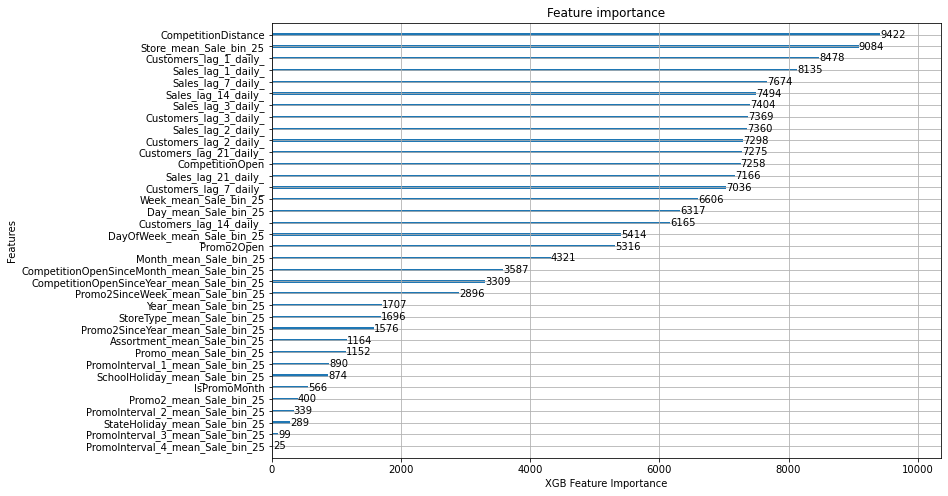

In [317]:
plt.rcParams["figure.figsize"] = (12,8)
xgb.plot_importance(model)
plt.xlabel("XGB Feature Importance")

In [320]:
preds = np.expm1(model.predict(dtest))
sample_submission = pd.DataFrame(preds,columns=['Sales'])
sample_submission['Id'] = list(range(1,len(preds)+1))
sample_submission= sample_submission.reindex(['Id','Sales'],axis=1)
sample_submission.head()


,Id,Sales
0,1,2788.003662
1,2,4202.187012
2,3,4680.822266
3,4,3984.821533
4,5,3020.932617


In [321]:
sample_submission.to_csv('sample_submission.csv',index=None)